Step 1: Imports and Dataset Load

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


# Load the preprocessed dataset
df = pd.read_csv('processed.csv')

Step 2: Define Features and Target

In [44]:
X = df.drop(columns=['C150_4'])
y = df['C150_4']

Step 3: Train/Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 4: Model Definitions

In [46]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "k-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
}

Step 5: Train and Evaluate Models

In [49]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({'Model': name, 'R²': r2, 'MSE': mse})

results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
display(results_df.style.format({'R²': '{:.4f}', 'MSE': '{:.4f}'}))


,Model,R²,MSE
1,Random Forest,0.8011,0.0054
0,Linear Regression,0.7942,0.0056
2,Decision Tree,0.7098,0.0079
4,Support Vector Regressor,0.5599,0.0119
3,k-Nearest Neighbors,0.4644,0.0145


Step 6: Visual Comparison of Predictions (for regression models)

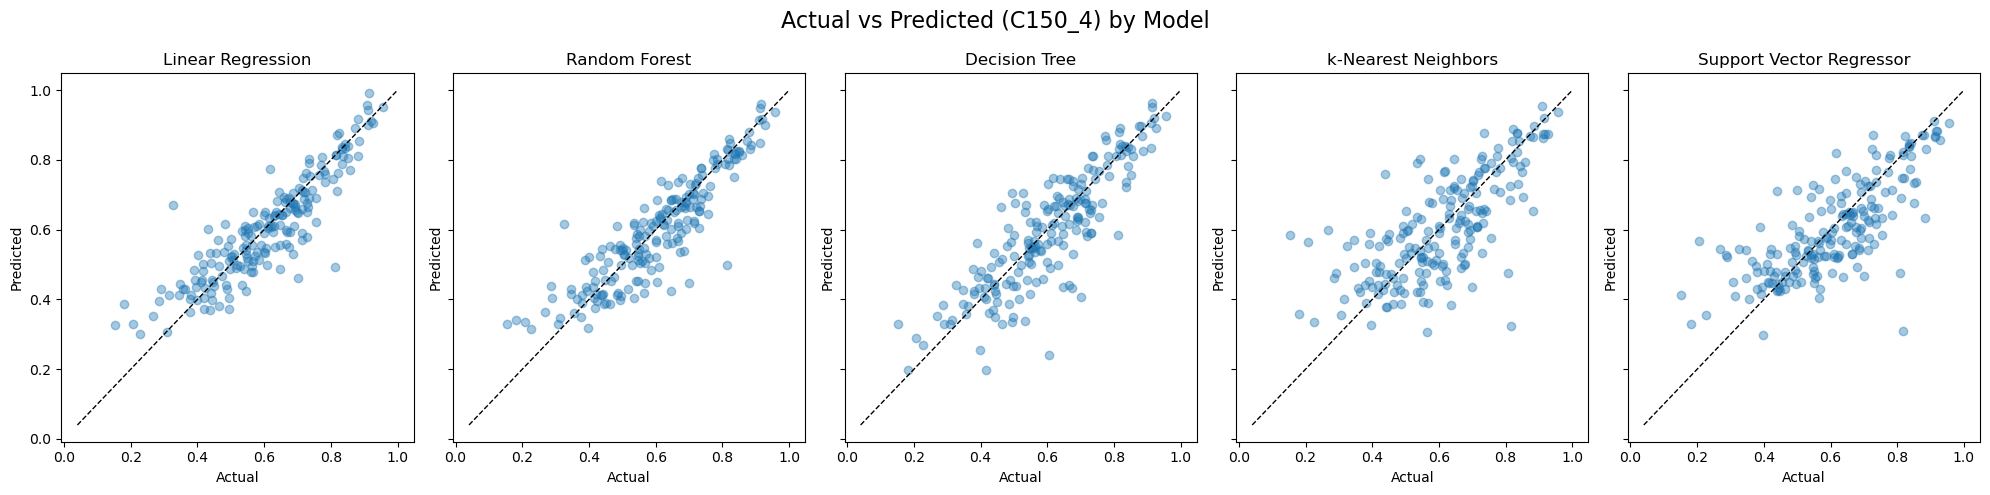

In [54]:
fig, axes = plt.subplots(1, len(models), figsize=(20, 5), sharex=True, sharey=True)

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    ax.scatter(y_test, y_pred, alpha=0.4)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_title(name)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

fig.suptitle("Actual vs Predicted (C150_4) by Model", fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/dn/6ddty5pj0t383r9xmwfs26s40000gn/T/ipykernel_65790/3692050428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R²', palette='Blues_d')


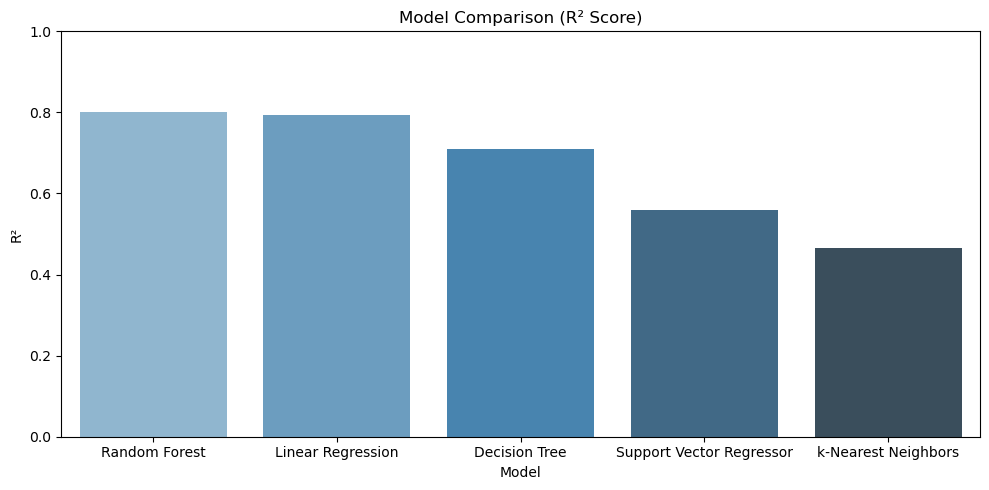

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R²', palette='Blues_d')
plt.title('Model Comparison (R² Score)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


/var/folders/dn/6ddty5pj0t383r9xmwfs26s40000gn/T/ipykernel_65790/1540814290.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='MSE', palette='Blues_d')


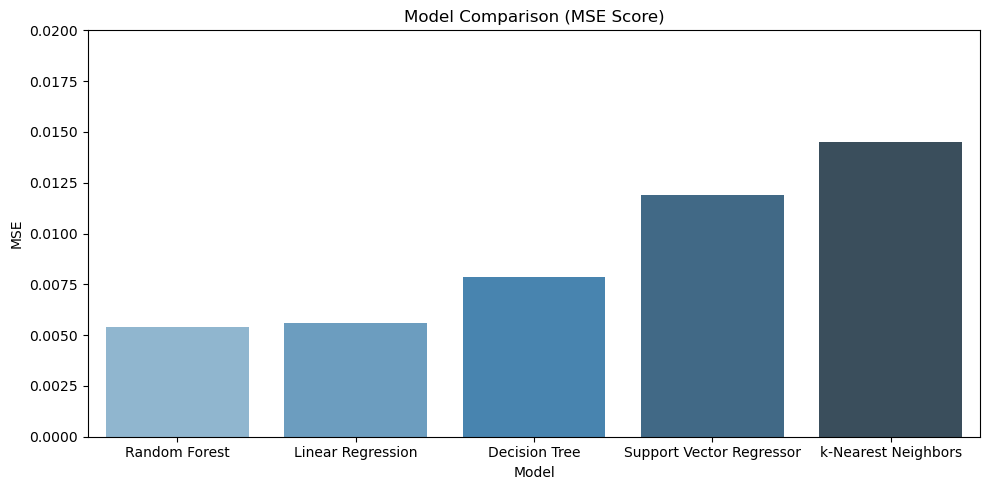

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='MSE', palette='Blues_d')
plt.title('Model Comparison (MSE Score)')
plt.ylim(0, .02)
plt.tight_layout()
plt.show()


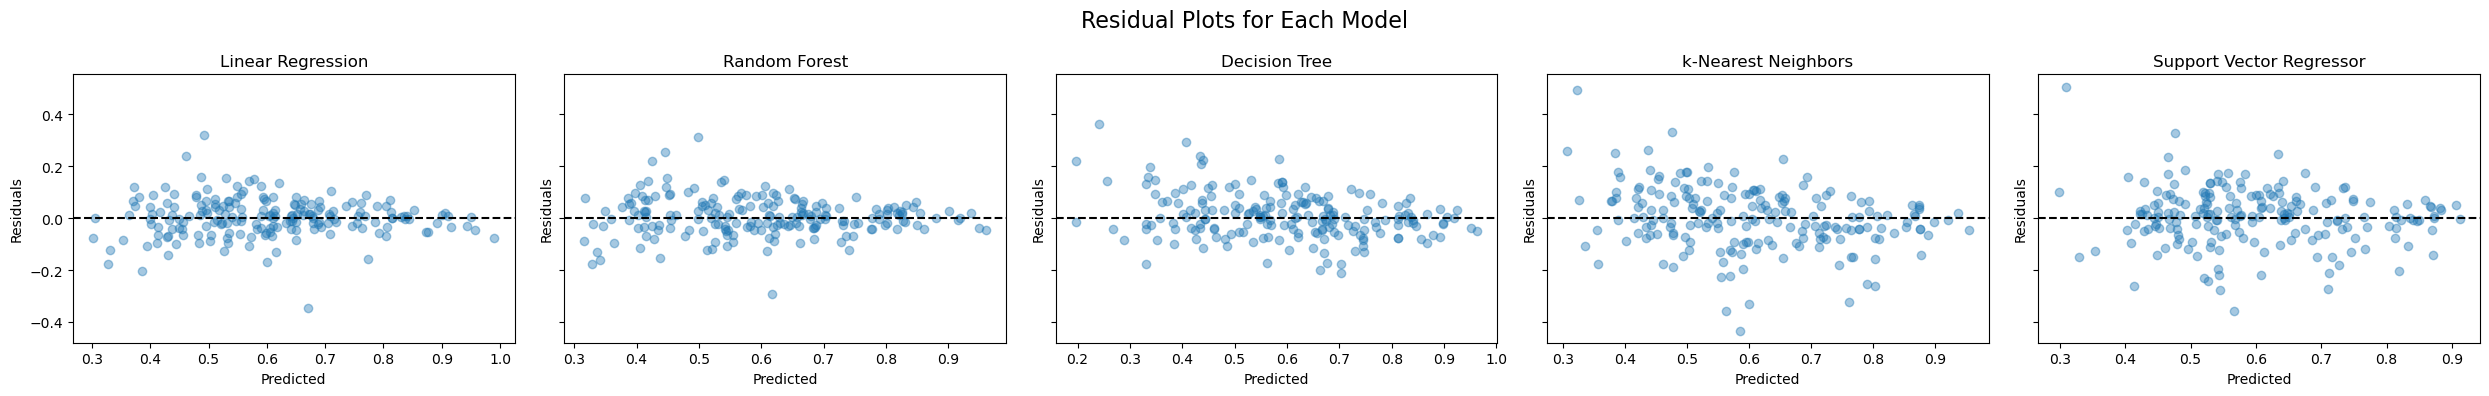

In [60]:
# Set up subplots
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4), sharey=True)

# Loop through models and plot residuals
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    ax.scatter(y_pred, residuals, alpha=0.4)
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")

fig.suptitle("Residual Plots for Each Model", fontsize=16)
plt.tight_layout()
plt.show()